# NN implemetation with Pythorch

## Imports

In [13]:
import numpy as np
import pandas as pd
import torch.nn as nn
import itertools
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
import csv

## Utils functions and classes

In [14]:
class CustomDataset(Dataset):
    """
    A custom dataset class compatible with PyTorch.
    """

    def __init__(self, X, Y):
        """
        Initializes the dataset with input data (X) and labels (Y).

        Args:
            X (array-like): Input data, e.g., features or independent variables.
            Y (array-like): Labels or targets associated with the input data.
        """
        # Converts the input data and labels to PyTorch tensors with dtype float32
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: The length of the dataset (number of samples).
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieves a specific sample from the dataset based on an index.

        Args:
            idx (int): Index of the desired sample.

        Returns:
            tuple: A tuple containing the input data and the corresponding label (X[idx], Y[idx]).
        """
        return self.X[idx], self.Y[idx]


class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait before stopping training if no improvement. Default: 5.
            delta (float): Minimum improvement required to consider progress. Default: 0.
            path (str): Path to save the best model. Default: 'checkpoint.pt'.
            verbose (bool): Print messages when the model improves. Default: False.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: No improvement for {self.counter} epochs")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save the model when validation loss improves."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [15]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history.

    Parameters:
    - history: History object returned by model.fit().
    """

    # Extract data from the history object
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_mee = history['train_mee']
    val_mee = history['val_mee']
    
    # Determine the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plot the training and validation loss
    plt.figure(figsize=(12, 5))  # Create a figure with a specific size
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')  # Plot training loss
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')  # Plot validation loss if available
    plt.title('Training and Validation Loss')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('Loss')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Plot the training and validation MEE
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
    if train_mee:
        plt.plot(epochs, train_mee, 'b-o', label='Training MEE')  # Plot training MEE if available
    if val_mee:
        plt.plot(epochs, val_mee, 'r-o', label='Validation MEE')  # Plot validation MEE if available
    plt.title('Training and Validation MEE')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('MEE')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Display the plots
    plt.show()

In [16]:
def plot_best_history(history):
    """
    Plot training and validation loss and accuracy from a model's history.

    Parameters:
    - history: History object returned by model.fit().
    """

    # Extract data from the history object
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_mee = history['train_mee']
    val_mee = history['val_mee']
    test_loss = history['test_loss']
    test_mee = history['test_mee']
    
    # Determine the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plot the training and validation loss and MEE
    plt.figure(figsize=(12, 5))  # Create a figure with a specific size
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')  # Plot training loss
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')  # Plot validation loss if available
    if test_loss:
        plt.plot(epochs, test_loss, 'g-o', label='Test Loss')  # Plot test loss if available
    plt.title('Training and Validation Loss')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('Loss')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Plot the training and validation MEE
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
    if train_mee:
        plt.plot(epochs, train_mee, 'b-o', label='Training MEE')  # Plot training MEE if available
    if val_mee:
        plt.plot(epochs, val_mee, 'r-o', label='Validation MEE')  # Plot validation MEE if available
    if test_mee:
        plt.plot(epochs, test_mee, 'g-o', label='Test MEE')  # Plot test MEE if available
    plt.title('Training and Validation MEE')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('MEE')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Display the plots
    plt.show()

In [17]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Generate all combinations of hyperparameters based on specified ranges and steps.

    Parameters
    ---------
    - param_ranges: Dictionary with hyperparameter names as keys.
                         Each value is a tuple (start, stop, step).

    Returns
    ---------
    - List of dictionaries with all possible combinations.
    """
    # Create a dictionary where each key is a hyperparameter name and each value is an array of possible values
    param_values = {
        key: np.arange(start, stop + step, step)  # Generate values from start to stop with the given step
        for key, (start, stop, step) in param_ranges.items()
    }
    
    # Generate all possible combinations of hyperparameter values
    param_combinations = list(itertools.product(*param_values.values()))
    
    # Convert each combination from a tuple to a dictionary
    return [
        dict(zip(param_values.keys(), combination))  # Create a dictionary for each combination
        for combination in param_combinations
    ]

## Model creation, train and evaluation

In [18]:
class NN(nn.Module):
    """
    A class to define a custom neural network using PyTorch.
    Supports configurable hidden layers and activation functions.
    """

    def __init__(self, input_size, hidden_size, output_size, hidden_layers, alpha, activ_type='tanh'):
        """
        Initializes the neural network with the specified parameters.

        Args:
            input_size (int): Number of neurons in the input layer.
            hidden_size (int): Number of neurons in each hidden layer.
            output_size (int): Number of neurons in the output layer.
            hidden_layers (int): Total number of hidden layers.
            alpha (float): Parameter for the LeakyReLU activation function (if selected).
            activ_type (str, optional): Type of activation function ('tanh', 'leaky_relu', 'relu'). Default is 'tanh'.
        """
        super(NN, self).__init__()

        # First fully connected layer (input -> hidden layer)
        self.fc_input = nn.Linear(input_size, hidden_size)

        # Hidden fully connected layers
        self.fc_hidden = [None] * (hidden_layers - 1)
        for i in range(hidden_layers - 1):
            self.fc_hidden[i] = nn.Linear(hidden_size, hidden_size)

        # Output fully connected layer (hidden -> output layer)
        self.fc_output = nn.Linear(hidden_size, output_size)

        # Select activation function based on the input string
        if activ_type.startswith("t"):
            self.activ_f = nn.Tanh()  # Hyperbolic tangent activation function
        elif activ_type.startswith("l"):
            self.activ_f = nn.LeakyReLU(alpha)  # LeakyReLU activation function with specified alpha
        elif activ_type.startswith("r"):
            self.activ_f = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: The output of the network after passing through all layers and activations.
        """
        # Apply the activation function to the input layer
        x = self.activ_f(self.fc_input(x))

        # Apply the activation function for each hidden layer
        for i in range(len(self.fc_hidden)):
            x = self.activ_f(self.fc_hidden[i](x))

        # Pass through the output layer and apply the linear function
        x = self.fc_output(x)

        return x

In [19]:
def fit(data_loader, model, learning_rate, momentum, weight_decay, epochs, patience, optim_type = 'SGD', reg_flag = False, val_data=[], val_labels=[]):
    """
    Trains a neural network model with optional regularization and early stopping.

    Args:
        data_loader (DataLoader): DataLoader for training data.
        model (nn.Module): The neural network model to train.
        learning_rate (float): Learning rate for the optimizer.
        momentum (float): Momentum value for the optimizer.
        weight_decay (float): Weight decay (L2 regularization) value.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        optim_type (str, optional): Optimizer type ('SGD' or 'Adam'). Default is 'SGD'.
        reg_flag (bool, optional): Whether to apply regularization. Default is False.
        val_data (list, optional): Validation data inputs. Default is an empty list.
        val_labels (list, optional): Validation data labels. Default is an empty list.

    Returns:
        dict: A dictionary containing the training history (loss and accuracy for both train and validation).
    """

    # Define the loss function (Mean Squared Error Loss)
    criterion = nn.MSELoss()

    # Set the optimizer based on the selected configuration
    if reg_flag:
        # If regularization is enabled, include weight decay in the optimizer
        if optim_type == 'Adam':
            optimizer = optim.Adam(
                model.parameters(), 
                lr=learning_rate, 
                momentum=momentum, 
                nesterov=True, 
                weight_decay=weight_decay
            )
        else:
            optimizer = optim.SGD(
                model.parameters(), 
                lr=learning_rate, 
                momentum=momentum, 
                nesterov=True, 
                weight_decay=weight_decay
            )
    else:
        # If regularization is not enabled, omit weight decay
        if optim_type == 'Adam':
            optimizer = optim.Adam(
                model.parameters(), 
                lr=learning_rate, 
                momentum=momentum, 
                nesterov=True 
            )
        else:
            optimizer = optim.SGD(
                model.parameters(), 
                lr=learning_rate, 
                momentum=momentum, 
                nesterov=True 
            )

    # Initialize a dictionary to track training and validation performance
    history = {'train_loss': [], 'train_mee': [], 'val_loss': [], 'val_mee': []}
    
    # Create an early stopping object to prevent overfitting
    early_stopping = EarlyStopping(patience, delta = 0.05, verbose=False)
    
    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_mee = 0  # Initialize total Mean Euclidean Error (MEE) for the epoch
        total_samples = 0  # Initialize total number of samples processed
        last_loss = 0  # Variable to store the last loss for the epoch
        
        # Iterate over batches in the training data
        for inputs, labels in data_loader:
            optimizer.zero_grad()  # Reset gradients before the backward pass
            outputs = model(inputs)  # Perform a forward pass through the model
            loss = criterion(outputs, labels.unsqueeze(1))  # Compute the loss between predictions and true labels
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update the model parameters using the optimizer

            last_loss = loss.item()  # Store the current loss for reporting

            # Calculate the Mean Euclidean Error (MEE) for the current batch
            batch_mee = torch.norm(outputs - labels.unsqueeze(1), dim=1).mean().item()
            total_mee += batch_mee  # Accumulate the MEE for the entire epoch
            total_samples += labels.size(0)  # Count the number of samples processed

        # Calculate the mean MEE for the entire epoch
        mean_mee_epoch = total_mee / total_samples
        history['train_loss'].append(last_loss)  # Record the training loss for the epoch
        history['train_mee'].append(mean_mee_epoch)  # Record the mean MEE for the epoch

        # Validation for the current epoch (if validation data is provided)
        if val_data is not None and val_labels is not None and len(val_data) > 0 and len(val_labels) > 0:
            result = evaluation(model, val_data, val_labels, criterion)  # Evaluate on validation set
            history['val_loss'].append(result[0])  # Record the validation loss
            history['val_mee'].append(result[1])  # Record the validation MEE
            early_stopping(result[0], model)  # Apply early stopping based on validation loss
            if early_stopping.early_stop:
                #print("Early stopping triggered!")  # Print message when early stopping is triggered
                break  # Stop training if early stopping criteria are met

    return history  # Return the training history

def evaluation(model, X, Y, criterion):
    """
    Evaluates the model on validation data.

    Args:
        model (nn.Module): The neural network model to evaluate.
        X (list or array-like): Input data.
        Y (list or array-like): Labels for the input data.
        criterion (nn.Module): Loss function to compute the loss.

    Returns:
        list: A list containing validation loss and MEE.
    """

    total_mee = 0  # Initialize total MEE for evaluation
    total_samples = 0  # Initialize total number of samples evaluated
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation (saves memory and computations)
        inputs = torch.tensor(X, dtype=torch.float32)  # Convert input data to tensor
        labels = torch.tensor(Y, dtype=torch.float32)  # Convert labels to tensor
        outputs = model(inputs)  # Perform a forward pass through the model
        loss = criterion(outputs, labels.unsqueeze(1))  # Calculate the loss (e.g., MSE loss)
        
        # Calculate the Mean Euclidean Error (MEE) for the validation data
        batch_mee = torch.norm(outputs - labels.unsqueeze(1), dim=1).mean().item()
        total_mee += batch_mee  # Accumulate the MEE
        total_samples += labels.size(0)  # Count the number of validation samples

        # Compute the mean MEE for the entire validation set
        mean_mee_epoch = total_mee / total_samples
        return [loss.item(), mean_mee_epoch]  # Return loss and MEE for the validation set



## Double-k-fold cross validation

In [20]:
def double_k_fold_cross_validation(data, labels, activ_type='tanh', optim_type='SGD',
                                   reg_flag=False, input_size=12, output_size=3, outer_k=5, inner_k=5, param_grid=None):
    """
    Implements Double K-Fold Cross-Validation

    Parameters
    ---------
     -   data (np.ndarray): Features of the dataset.
     -   labels (np.ndarray): Labels of the dataset.
     -   activ_type (str): Activation function type.
     -   optim_type (str): Optimizer type.
     -   reg_flag (bool): Regularization flag.
     -   input_size (int): Input size.
     -   output_size (int): Output size.
     -   outer_k (int): Number of folds for outer cross-validation.
     -   inner_k (int): Number of folds for inner cross-validation.
     -   param_grid (list): List of dictionaries with hyperparameters to try.
    
    Returns:
    ----------
     -   list: List of scores obtained for each outer fold.
     -   list: List of best parameters for each outer fold.
    """
    outer_scores = []
    outer_params = []
    
    # Configuration of the outer k-fold cross-validation
    out_kfold = KFold(n_splits=outer_k, shuffle=True, random_state=42)

    # Outer cross-validation loop
    out_fold_no = 1
    for train_index, val_index in out_kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the outer fold
        out_X_train, out_X_val = data[train_index], data[val_index]
        out_y_train, out_y_val = labels[train_index], labels[val_index]
        
        best_params = {}
        best_score = -np.inf

        # Iterate over each set of hyperparameters in the parameter grid
        for params in param_grid:

            inner_scores = []

            # Inner cross-validation loop
            inner_fold_no = 1
            inner_kfold = KFold(n_splits=inner_k, shuffle=True, random_state=42)

            for train_index, val_index in inner_kfold.split(out_X_train, out_y_train):
                
                # Split the dataset into training and validation sets for the inner fold
                inner_X_train, inner_X_val = out_X_train[train_index], out_X_train[val_index]
                inner_y_train, inner_y_val = out_y_train[train_index], out_y_train[val_index]

                # Create a custom dataset using the training data (features and labels)
                dataset = CustomDataset(inner_X_train, inner_y_train)

                # Initialize a DataLoader to iterate over the dataset in mini-batches
                # - batch_size: Size of each batch, taken from the 'params' dictionary
                # - shuffle: Set to False to maintain the original order of the data
                data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

                # Create the neural network model
                model = NN(input_size=input_size, hidden_size=params['hidden_size'], output_size=output_size,
                           hidden_layers=params['hidden_layers'], alpha=params['alpha'], activ_type=activ_type)
                
                # Train the model and obtain the history
                history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                              weight_decay=params['regularization'], momentum=params['momentum'],
                              epochs=params['epochs'], patience=params['patience'], optim_type=optim_type, reg_flag=reg_flag, val_data=inner_X_val, val_labels=inner_y_val)

                # Append the minimum validation MEE to inner scores
                inner_scores.append(min(history['val_mee']))
                inner_fold_no += 1
            
            # Calculate the average score for the current set of hyperparameters
            avg_score = np.mean(inner_scores)

            # Update the best score and parameters if the current average score is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        

        # Train the final model on the outer training set with the best hyperparameters
        dataset = CustomDataset(out_X_train, out_y_train)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        final_model = NN(input_size=input_size, hidden_size=params['hidden_size'], output_size=output_size, 
                         hidden_layers=params['hidden_layers'], alpha=params['alpha'], activ_type=activ_type)
        
        history = fit(data_loader=data_loader, model=final_model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience=params['patience'], optim_type=optim_type, reg_flag=reg_flag, val_data=out_X_val, val_labels=out_y_val)
        
        # Append the maximum validation MEE to outer scores
        outer_scores.append(min(history['val_mee']))
        outer_params.append(best_params)

        out_fold_no += 1
    
    return outer_scores, outer_params

## K-fold cross validation

In [21]:
def k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size =12, output_size = 3, params=None):
    """
    Perform k-fold cross-validation on the given dataset using a neural network model.

    Parameters:
    ----------
    - data (np.ndarray): Features of the dataset.
    - labels (np.ndarray): Labels of the dataset.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - in_size (int): Number of input features.
    - params (dict): Dictionary containing hyperparameters for the model.

    Returns:
    --------
    - avg_score (float): Average validation MEE across all folds.
    - history (tf.keras.callbacks.History): Training history of the final model.
    - model (tf.keras.Model): Trained Keras model.
    """


    # Configuration of k-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation loop
    fold_no = 1
    mee_per_fold = []
    for train_index, val_index in kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the current fold
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        

        dataset = CustomDataset(X_train, y_train)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        # Create the neural network model
        model = NN(input_size = input_size,
                    hidden_size = params['hidden_size'],
                    output_size = output_size,
                    hidden_layers = params['hidden_layers'], 
                    alpha=params['alpha'],
                    activ_type = activ_type)
        
        
        # Train the model and obtain the histor
        history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, val_labels=y_val)
        

        # Get the best score (minimum validation MEE)
        score = min(history['val_mee'])
        mee_per_fold.append(score)
        fold_no += 1

    # Calculate the average score across all folds
    avg_score = np.mean(mee_per_fold)

    # Split the dataset into training and validation sets for the final training
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    # Create the neural network model for the final training
    dataset = CustomDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

    model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size,
               hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
        
    history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, val_labels=y_val)

    # Return the average score, training history, and the final model
    return avg_score, history, model


## Data loading

In [22]:
# Load dataset
train_path = '../Datasets/CUP/ML-CUP24-TR.csv'  # Path to the training dataset
test_path = '../Datasets/CUP/ML-CUP24-TS.csv'   # Path to the test dataset

# Load the training data, skipping the first 7 rows
data_train = pd.read_csv(train_path, skiprows=7, delimiter=',')  
# Load the test data, skipping the first 7 rows
data_blind_test = pd.read_csv(test_path, skiprows=7, delimiter=',', header=None) 

print(data_blind_test.shape)

# Drop the ID column and split inputs/outputs for training data
X_train = data_train.iloc[:, 1:-3].values  # Extract input features (all columns except the first and last three)
y_train = data_train.iloc[:, -3:].values   # Extract target values (last three columns: TARGET_x, TARGET_y, TARGET_z)

# Split the training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Drop the ID column and extract input features for the test data
X_blind_test = data_blind_test.iloc[:, 1:].values  # Extract input features (all columns except the first)

# Standardize inputs (mean 0, std 1)
input_scaler = StandardScaler()  # Initialize the StandardScaler for input features
X_train_scaled = input_scaler.fit_transform(X_train)  # Fit the scaler on training data and transform it
X_test_scaled = input_scaler.transform(X_test)  # Transform the validation data using the same scaler
X_blind_test_scaled = input_scaler.transform(X_blind_test)  # Transform the test data using the same scaler

# Normalize outputs (Min-Max scaling to [0, 1])
output_scaler = MinMaxScaler()  # Initialize the MinMaxScaler for output values
y_train_scaled = output_scaler.fit_transform(y_train)  # Fit the scaler on training target values and transform them
y_test_scaled = output_scaler.transform(y_test)  # Transform the validation target values using the same scaler


(500, 13)


## Greedy Search

In [23]:
def greed_search(data, labels, activ_type='tanh', optim_type='SGD', reg_flag=False, input_size=12, output_size=3, param_grid=None):
    """
    Perform a greedy search over the hyperparameter grid to find the best model configurations.

    Parameters:
    ----------
    - data (np.ndarray): Features of the dataset.
    - labels (np.ndarray): Labels of the dataset.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - input_size (int): Number of input features.
    - param_grid (list): List of dictionaries with hyperparameters to try.

    Returns:
    --------
    - best_scores (list): List of the best scores obtained.
    - best_params_list (list): List of the best hyperparameter configurations.
    - best_models (list): List of the best trained models.
    - best_histories (list): List of the training histories of the best models.
    """
    
    # Initialize lists to store the best scores, parameters, models, and training histories
    best_scores = []
    best_params_list = []
    best_models = []
    best_histories = []

    # Iterate over each set of hyperparameters in the parameter grid
    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")

        # Perform k-fold cross-validation with the current set of hyperparameters
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, input_size=input_size, output_size=output_size, params=params)
        print(f"Score : {score}")

        # Add the results to the lists
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Sort the scores in ascending order and keep the top 10
        sorted_indices = np.argsort(best_scores)
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Keep the top 10 scores
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]  # Keep the top 10 hyperparameter configurations
        best_models = [best_models[i] for i in sorted_indices][:10]  # Keep the top 10 models
        best_histories = [best_histories[i] for i in sorted_indices][:10]  # Keep the top 10 training histories

    print("--------------------END GREED SEARCH------------------------------")

    # Return the top 10 best results
    return best_scores, best_params_list, best_models, best_histories


## Model selection

Generating hyperparameter combinations...
--------------------------------------------------ML CUP--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 30, 'hidden_layers': 2, 'momentum': 0.2, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}


/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128, 1, 3])) that is different to the input size (torch.Size([128, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([51, 1, 3])) that is different to the input size (torch.Size([51, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([45, 1, 3])) that is different to the input size (torch.Size([45, 3])). This will likely lead to incorrect results due to broadcasting. Please

Score : 0.03759607197058321
--------------------------------------------------
Testing params: {'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 30, 'hidden_layers': 2, 'momentum': 0.30000000000000004, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score : 0.03456848505771521
--------------------------------------------------
Testing params: {'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 30, 'hidden_layers': 2, 'momentum': 0.4000000000000001, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score : 0.035012656173320736
--------------------------------------------------
Testing params: {'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 30, 'hidden_layers': 2, 'momentum': 0.5000000000000001, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score : 0.03430424791393858
--------------------------------------------------
Testing params: {'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hid

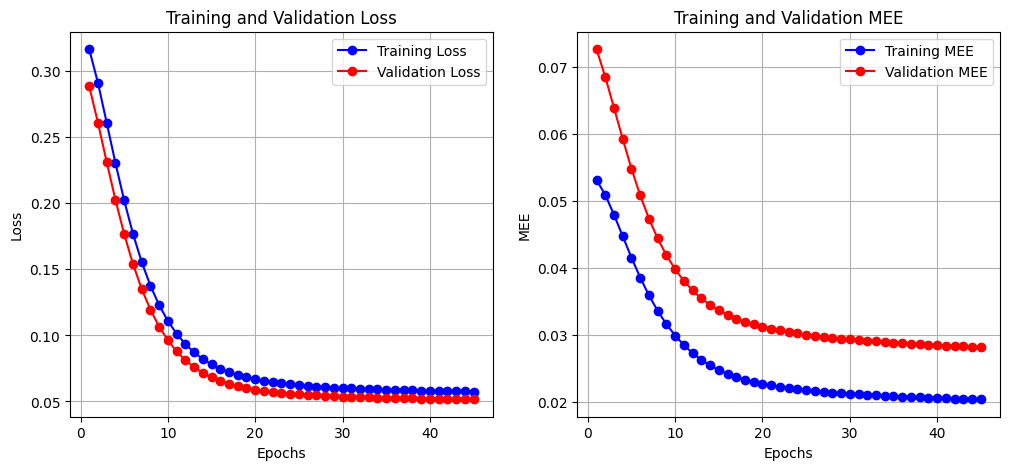

{'learning_rate': 0.01, 'epochs': 700, 'batch_size': 128, 'hidden_size': 70, 'hidden_layers': 2, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.02931350539429019


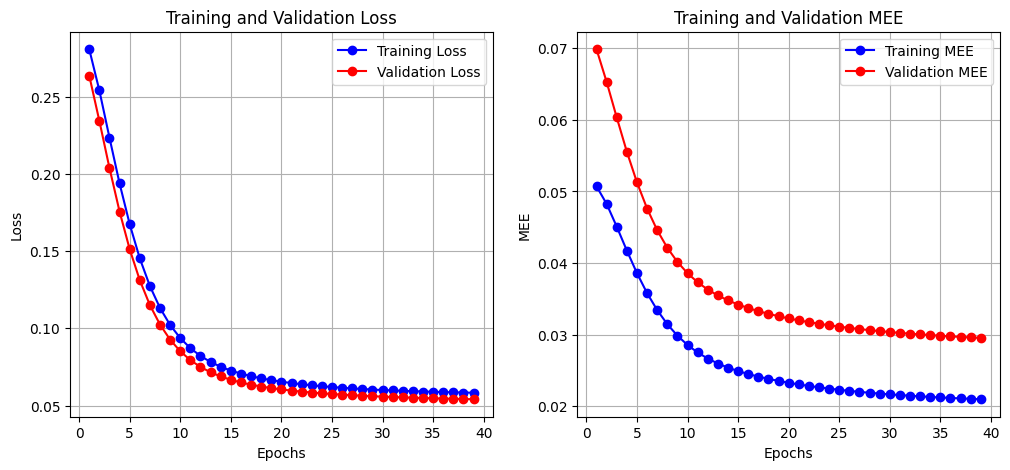

{'learning_rate': 0.009000000000000001, 'epochs': 700, 'batch_size': 128, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.02938932063603642


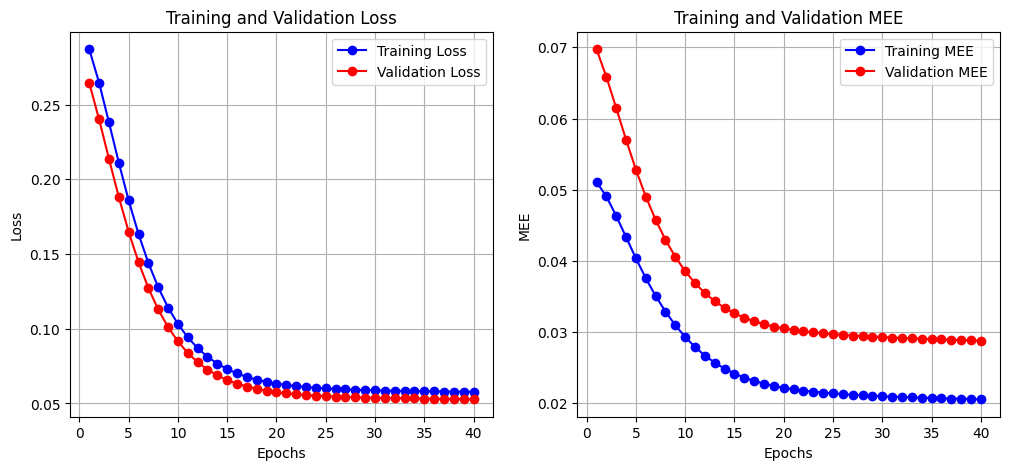

{'learning_rate': 0.01, 'epochs': 700, 'batch_size': 128, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.02945114294687907


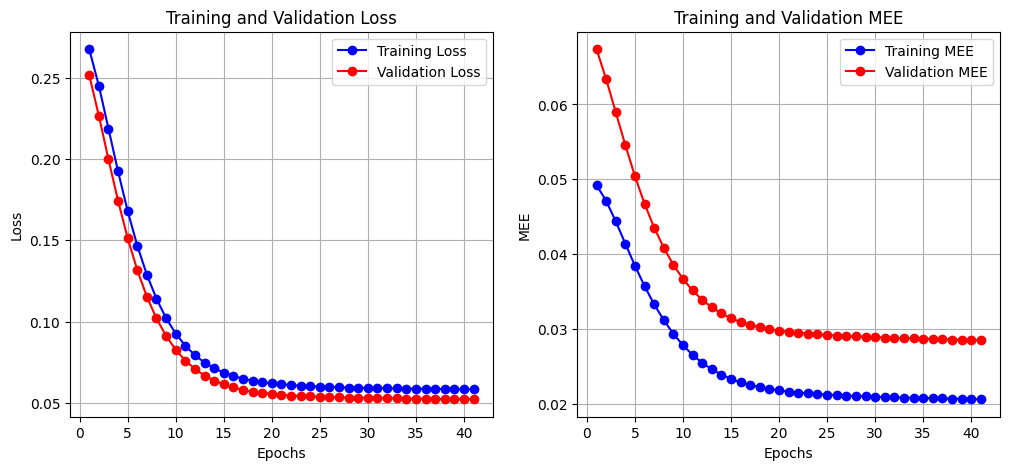

{'learning_rate': 0.009000000000000001, 'epochs': 700, 'batch_size': 128, 'hidden_size': 70, 'hidden_layers': 2, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.029452575252513692


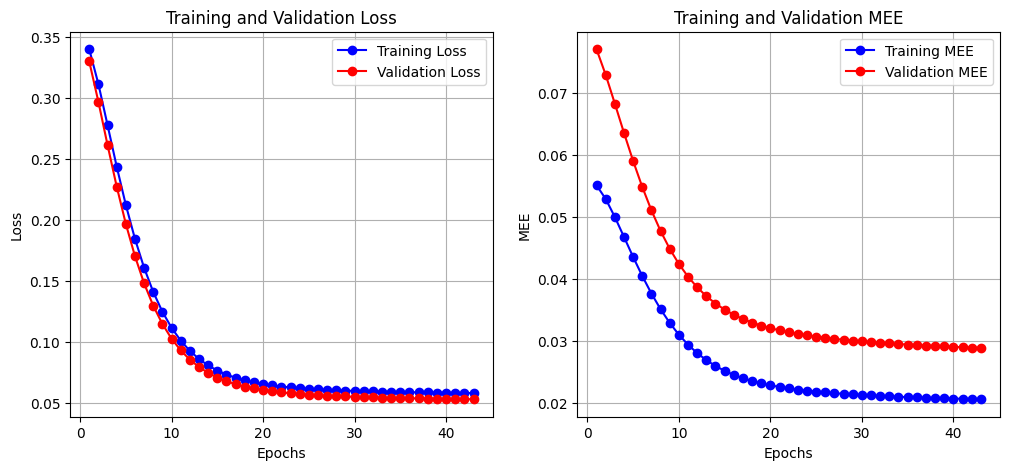

{'learning_rate': 0.01, 'epochs': 700, 'batch_size': 128, 'hidden_size': 50, 'hidden_layers': 2, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.029467561437626077


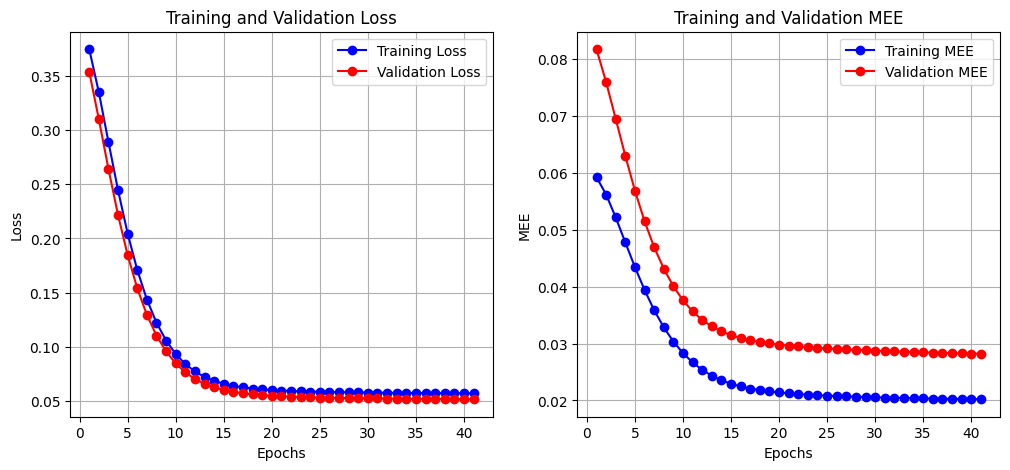

{'learning_rate': 0.009000000000000001, 'epochs': 700, 'batch_size': 128, 'hidden_size': 50, 'hidden_layers': 2, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.02950437896179431


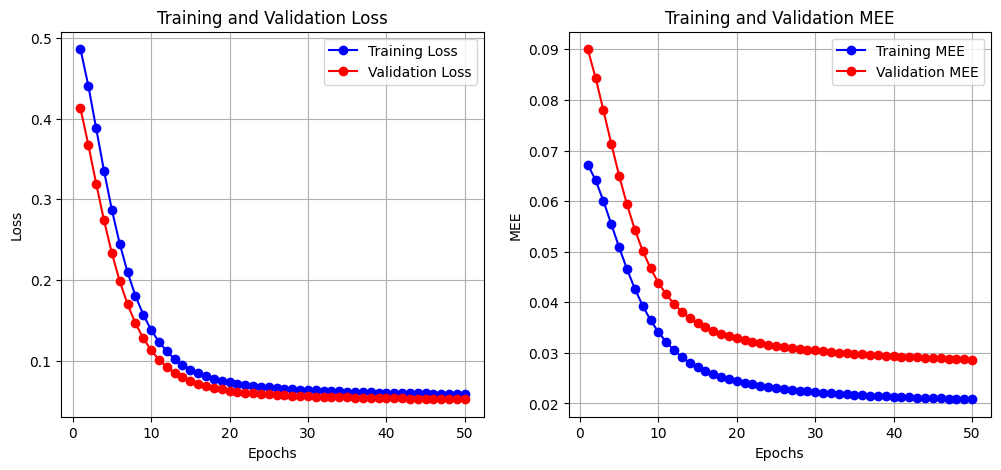

{'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.02950494767439486


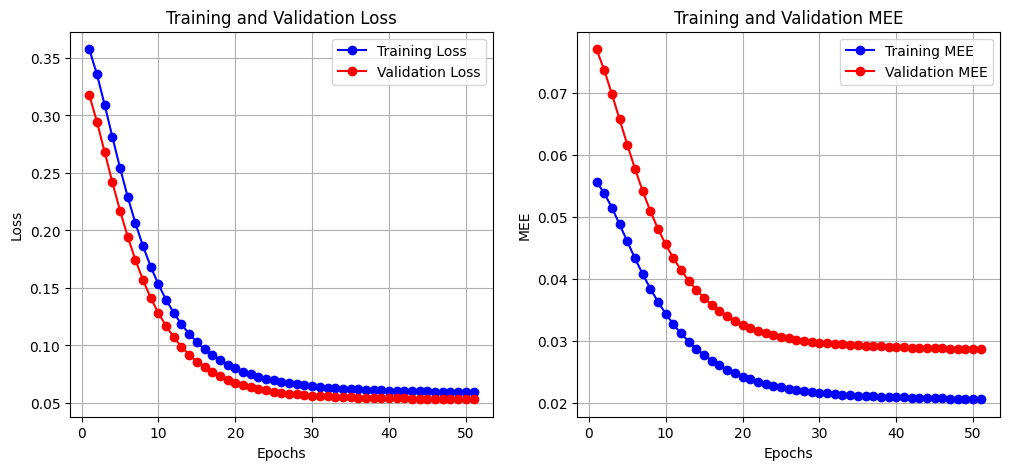

{'learning_rate': 0.009000000000000001, 'epochs': 700, 'batch_size': 128, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.02950829722664573


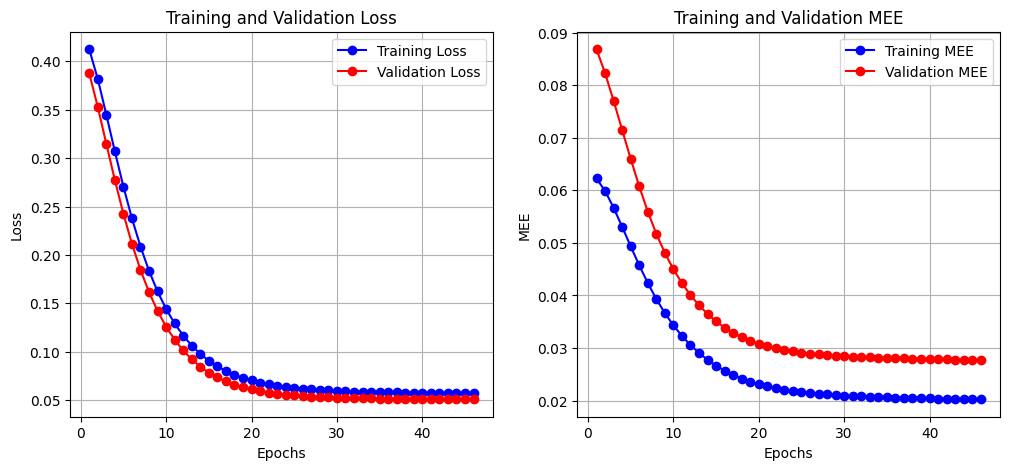

{'learning_rate': 0.009000000000000001, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.029524730576409232


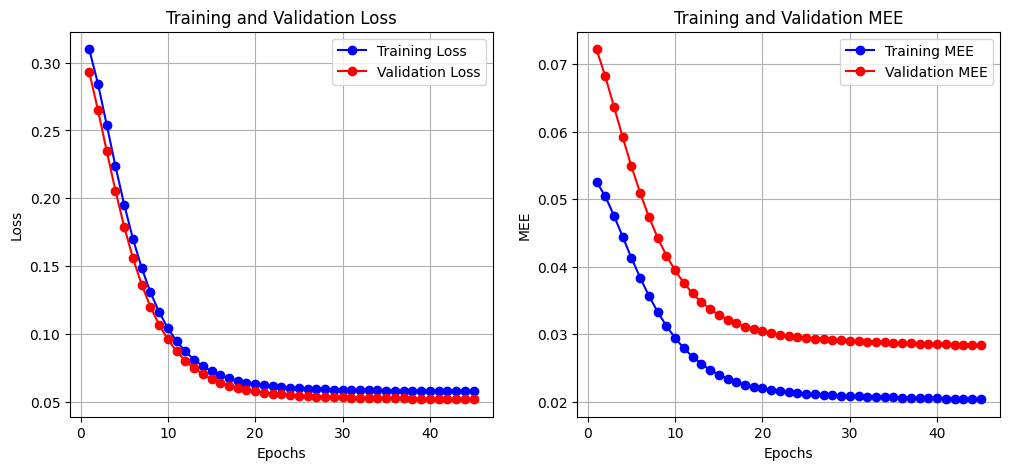

In [24]:
# Initialize lists to store the best scores, parameters, models, and training histories for each dataset
best_scores = []  # List to store the best scores for each dataset
best_params_list = []  # List to store the best hyperparameter configurations for each dataset
best_models = []  # List to store the best models for each dataset
best_histories = []  # List to store the training histories for each dataset

# Determine the input and output sizes based on the scaled training data
input_size = X_train_scaled.shape[1]  # Number of input features
output_size = 3  # Number of output features

# Define the range of hyperparameters for the grid search
param_ranges_1 = {
    "learning_rate": (0.007, 0.01, 0.001),  # Learning rate range from 0.007 to 0.01 with a step of 0.001
    "epochs": (700, 700, 1),  # Number of epochs fixed at 700
    "batch_size": (128, 128, 1),  # Batch size fixed at 128
    "hidden_size": (30, 80, 10),  # Hidden layer size range from 30 to 80 with a step of 10
    "hidden_layers": (2, 3, 1),  # Number of hidden layers range from 2 to 3 with a step of 1
    "momentum": (0.2, 0.8, 0.1),  # Momentum range from 0.2 to 0.8 with a step of 0.1
    "regularization": (0.01, 0.01, 0.01),  # Regularization fixed at 0.01
    "alpha": (0.01, 0.01, 0.01),  # Alpha fixed at 0.01
    "patience": (30, 30, 1)  # Patience fixed at 30
}

# Generate all combinations of hyperparameters based on the specified ranges
print("Generating hyperparameter combinations...")
param_grid_monk1 = generate_hyperparameter_combinations(param_ranges_1)

print("--------------------------------------------------ML CUP--------------------------------------------------")
# Perform a greedy search over the hyperparameter grid
best_scores, best_params_list, best_models, best_histories = greed_search(X_train_scaled, y_train_scaled, 
                                                                          'tanh', 'SGD', True, 
                                                                          input_size, output_size, param_grid_monk1)

print("--------------------------------------------------Plots--------------------------------------------------")
# Iterate over the best histories, parameters, and scores to print and plot the results
for i, (history, params, score) in enumerate(zip(best_histories, best_params_list, best_scores)):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the score
    plot_training_history(history)  # Plot the training history


In [25]:
# Determine the input and output sizes based on the scaled training data
input_size = X_train_scaled.shape[1]  # Number of input features
output_size = y_train_scaled.shape[1]  # Number of output features

# Generate all possible combinations of hyperparameters based on the specified ranges
param_grid_1 = [best_params_list[0]]  # Use the best hyperparameters from the previous search

# Perform double k-fold cross-validation with the specified parameters
scores, _ = double_k_fold_cross_validation(X_train_scaled, y_train_scaled, 
                                           activ_type='tanh', optim_type='SGD', 
                                           reg_flag=True, input_size=input_size, 
                                           output_size=output_size, outer_k=5, 
                                           inner_k=5, param_grid=param_grid_1)

# Calculate the variance of the scores obtained from cross-validation
variance = np.var(scores)

# Calculate the mean of the scores obtained from cross-validation
mean = np.mean(scores)

# Print the mean and variance of the scores
print(f"Mean: {mean}")
print(f"Variance: {variance}")

/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15, 1, 3])) that is different to the input size (torch.Size([15, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36, 1, 3])) that is different to the input size (torch.Size([36, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 3])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please e

Mean: 0.029868404768934154
Variance: 2.9286752694015804e-06


## Model assessment

In [26]:
_, test_mee, = evaluation(best_models[0], X_test_scaled, y_test_scaled, nn.MSELoss())
print(test_mee)

0.038021256923675535


/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([25, 1, 3])) that is different to the input size (torch.Size([25, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [27]:
print(min(best_histories[0]['train_mee']))

0.020386843707974396


## Plot best model

In [28]:
def fit_best(data_loader, model, learning_rate, momentum, weight_decay, epochs, patience, optim_type = 'SGD', reg_flag = False, val_data=[], val_labels=[], test_data=[], test_labels=[]):
    """
    Trains a neural network model with optional regularization and early stopping.

    Args:
        data_loader (DataLoader): DataLoader for training data.
        model (nn.Module): The neural network model to train.
        learning_rate (float): Learning rate for the optimizer.
        momentum (float): Momentum value for the optimizer.
        weight_decay (float): Weight decay (L2 regularization) value.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        optim_type (str, optional): Optimizer type ('SGD' or 'Adam'). Default is 'SGD'.
        reg_flag (bool, optional): Whether to apply regularization. Default is False.
        val_data (list, optional): Validation data inputs. Default is an empty list.
        val_labels (list, optional): Validation data labels. Default is an empty list.
        test_data (list, optional): Test data inputs. Default is an empty list.
        test_labels (list, optional): Test data labels. Default is an empty list.

    Returns:
        dict: A dictionary containing the training history (loss and accuracy for both train and validation).
    """

    # Define the loss function (Mean Squared Error Loss)
    criterion = nn.MSELoss()

    # Set the optimizer based on the selected configuration
    if reg_flag:
        # If regularization is enabled, include weight decay in the optimizer
        if optim_type == 'Adam':
            optimizer = optim.Adam(
                model.parameters(), 
                lr=learning_rate, 
                weight_decay=weight_decay
            )
        else:
            optimizer = optim.SGD(
                model.parameters(), 
                lr=learning_rate, 
                momentum=momentum, 
                nesterov=True, 
                weight_decay=weight_decay
            )
    else:
        # If regularization is not enabled, omit weight decay
        if optim_type == 'Adam':
            optimizer = optim.Adam(
                model.parameters(), 
                lr=learning_rate
            )
        else:
            optimizer = optim.SGD(
                model.parameters(), 
                lr=learning_rate, 
                momentum=momentum, 
                nesterov=True 
            )

    # Initialize a dictionary to track training and validation performance
    history = {'train_loss': [], 'train_mee': [], 'val_loss': [], 'val_mee': [], 'test_loss': [], 'test_mee': []}
    
    # Create an early stopping object to prevent overfitting
    early_stopping = EarlyStopping(patience, delta = 0.05, verbose=False)
    
    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_mee = 0  # Initialize total Mean Euclidean Error (MEE) for the epoch
        total_samples = 0  # Initialize total number of samples processed
        last_loss = 0  # Variable to store the last loss for the epoch
        
        # Iterate over batches in the training data
        for inputs, labels in data_loader:
            optimizer.zero_grad()  # Reset gradients before the backward pass
            outputs = model(inputs)  # Perform a forward pass through the model
            loss = criterion(outputs, labels.unsqueeze(1))  # Compute the loss between predictions and true labels
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update the model parameters using the optimizer

            last_loss = loss.item()  # Store the current loss for reporting

            # Calculate the Mean Euclidean Error (MEE) for the current batch
            batch_mee = torch.norm(outputs - labels.unsqueeze(1), dim=1).mean().item()
            total_mee += batch_mee  # Accumulate the MEE for the entire epoch
            total_samples += labels.size(0)  # Count the number of samples processed

        # Calculate the mean MEE for the entire epoch
        mean_mee_epoch = total_mee / total_samples
        history['train_loss'].append(last_loss)  # Record the training loss for the epoch
        history['train_mee'].append(mean_mee_epoch)  # Record the mean MEE for the epoch

        # Evaluate on test data if provided
        if test_data is not None and test_labels is not None and len(val_data) > 0 and len(val_labels) > 0:
            result = evaluation(model, test_data, test_labels, criterion)  # Evaluate on test set
            history['test_loss'].append(result[0])  # Record the test loss
            history['test_mee'].append(result[1])  # Record the test MEE      

        # Validation for the current epoch (if validation data is provided)
        if val_data is not None and val_labels is not None and len(val_data) > 0 and len(val_labels) > 0:
            result = evaluation(model, val_data, val_labels, criterion)  # Evaluate on validation set
            history['val_loss'].append(result[0])  # Record the validation loss
            history['val_mee'].append(result[1])  # Record the validation MEE
            early_stopping(result[0], model)  # Apply early stopping based on validation loss
            if early_stopping.early_stop:
                # Print message when early stopping is triggered
                break  # Stop training if early stopping criteria are met

    return history  # Return the training history


In [29]:
def best_k_fold_cross_validation(data, labels, data_test, data_labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size =12, output_size = 3, params=None):
    """
    Perform k-fold cross-validation on the given dataset using a neural network model.

    Parameters:
    ----------
    - data (np.ndarray): Features of the dataset.
    - labels (np.ndarray): Labels of the dataset.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - in_size (int): Number of input features.
    - params (dict): Dictionary containing hyperparameters for the model.

    Returns:
    --------
    - avg_score (float): Average validation MEE across all folds.
    - history (tf.keras.callbacks.History): Training history of the final model.
    - model (tf.keras.Model): Trained Keras model.
    """


    # Configuration of k-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation loop
    fold_no = 1
    mee_per_fold = []
    for train_index, val_index in kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the current fold
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        

        dataset = CustomDataset(X_train, y_train)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        # Create the neural network model
        model = NN(input_size = input_size,
                    hidden_size = params['hidden_size'],
                    output_size = output_size,
                    hidden_layers = params['hidden_layers'], 
                    alpha=params['alpha'],
                    activ_type = activ_type)
        
        
        # Train the model and obtain the histor
        history = fit_best(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                        weight_decay=params['regularization'], momentum=params['momentum'],
                        epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, val_labels=y_val, 
                        test_data = data_test, test_labels = data_labels)
        

        # Get the best score (minimum validation MEE)
        score = min(history['val_mee'])
        mee_per_fold.append(score)
        fold_no += 1

    # Calculate the average score across all folds
    avg_score = np.mean(mee_per_fold)

    # Split the dataset into training and validation sets for the final training
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    # Create the neural network model for the final training
    dataset = CustomDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

    model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size,
               hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
        
    history = fit_best(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], 
                      optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, 
                      val_labels=y_val, test_data = data_test, test_labels = data_labels)

    # Return the average score, training history, and the final model
    return avg_score, history, model


{'learning_rate': 0.009000000000000001, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.8000000000000003, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.029509138121749417


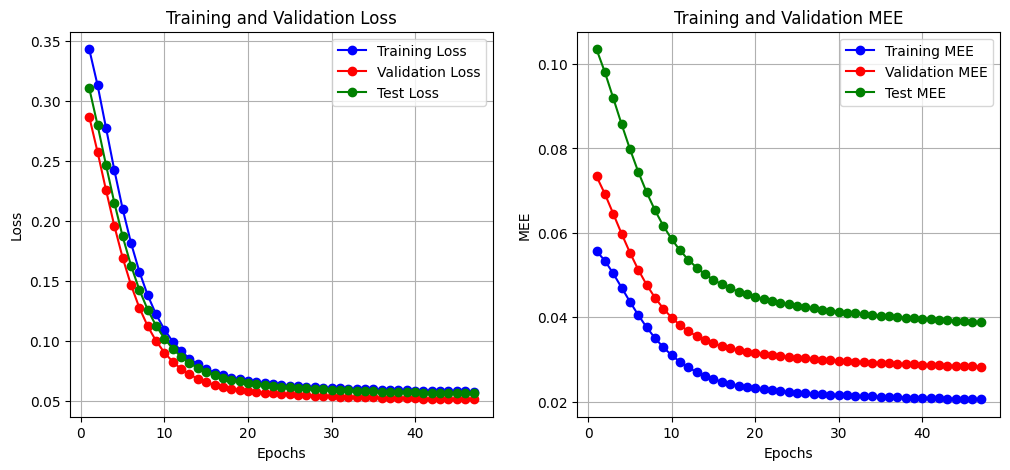

In [30]:
# Determine the input and output sizes based on the scaled training data
input_size = X_train_scaled.shape[1]  # Number of input features
output_size = y_train_scaled.shape[1]  # Number of output features

# Perform k-fold cross-validation with the current set of hyperparameters
score, history, model_cup = best_k_fold_cross_validation(
    X_train_scaled,  # Scaled training input data
    y_train_scaled,  # Scaled training output data
    X_test_scaled,   # Scaled validation input data
    y_test_scaled,   # Scaled validation output data
    activ_type='tanh',  # Activation function type
    optim_type='SGD',   # Optimizer type
    reg_flag=True,      # Flag to indicate whether to use L2 regularization
    input_size=input_size,  # Number of input features
    output_size=output_size,  # Number of output features
    params=best_params_list[0]  # Best hyperparameters from the previous search
)

# Print the best hyperparameters
print(f"{params}")

# Print the score obtained from k-fold cross-validation
print(f"Score: {score}")

# Plot the training history including training, validation, and test metrics
plot_best_history(history)

## Result for blind test

In [31]:
# Convert the blind test data into a PyTorch dataset
# Data for the first 4 lines of the file
names = "Giuseppe Gabriele Russo, Mario Mogavero"  # Replace with your names
team = "Team Rocket"  # Replace with your team nickname
dataset_name = "ML-CUP24 v1"  # Dataset name
date = datetime.datetime.now().strftime("%d %b %Y")  # Current date formatted

# Disable gradient calculation for evaluation (saves memory and computations)
with torch.no_grad():
        inputs = torch.tensor(X_blind_test_scaled, dtype=torch.float)  # Convert input data to tensor
        y_blind_test_scaled = model_cup(inputs)  # Perform a forward pass through the model to get predictions

# Denormalize the predictions
y_blind_test = output_scaler.inverse_transform(y_blind_test_scaled)

# Save the results to a CSV file
ids = range(1, len(X_blind_test_scaled) + 1)  # Generate IDs for each prediction
output_filename = "../pytorchCUP_pred.csv"  # Output file path
with open(output_filename, mode="w", newline="") as file:
        writer = csv.writer(file)

        # Write the first 4 lines as comments
        writer.writerow([f"# {names}"])
        writer.writerow([f"# {team}"])
        writer.writerow([f"# {dataset_name}"])
        writer.writerow([f"# {date}"])

        # Write the results
        for i, result in zip(ids, y_blind_test):
                writer.writerow([i, result[0], result[1], result[2]])  # Write ID and prediction values

print(f"File '{output_filename}' generated successfully!")


File '../pytorchCUP_pred.csv' generated successfully!
